# Better GAM — Demonstration notebook  
A reference implementation of the **Genetic Associative Memory** (GAM) model  
augmented with inhibitory traces (X) supporting *latent inhibition* and  
*classical extinction*, based on Sorek *et al.* 2013.  

2. Shows qualitative behaviours: learning, erasing, classical extinction, latent inhibition.  
3. Replicates Fig 5B/5C capacity curves for `s = 0` (sanity check).  
4. Explores how capacity changes when `s > 0`.  

Feel free to tweak parameters and protocols.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Union, Optional, List
from BetterGAM import BetterGAM
# Plot style
plt.rcParams['figure.dpi'] = 120


In [2]:
def random_cs(N: int, f: float = 0.5, rng=None, seed=None) -> np.ndarray:
    rng = rng or np.random.default_rng(seed=seed)
    return (rng.random(N) < f)

def run_protocol(model, cs_seq, us_seq):
    responses, m_trace, x_trace = [], [], []
    for C, U in zip(cs_seq, us_seq):
        model.present(C, U)
        responses.append(model.response(C, U))
        m_trace.append(model.get_m().mean())
        x_trace.append(model.get_x().mean())
    return np.array(responses), np.array(m_trace), np.array(x_trace)

def sigmoid(x, beta=3.0):
    """Sigmoid function."""
    return 1 / (1 + np.exp(-beta * (x - 0.5)))

def elementwise_sigmoid(C,M, beta=3.0) -> float:
    mean = np.mean(C.flatten() * M.flatten()).astype(float)
    return sigmoid(mean, beta=beta)


[0 1 0 0 1]


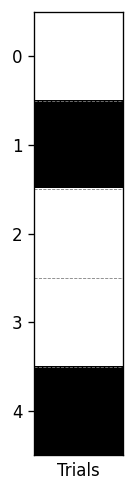

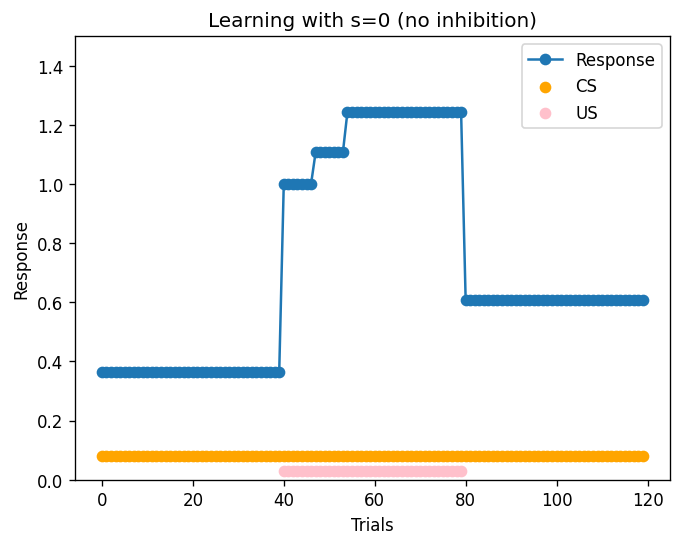

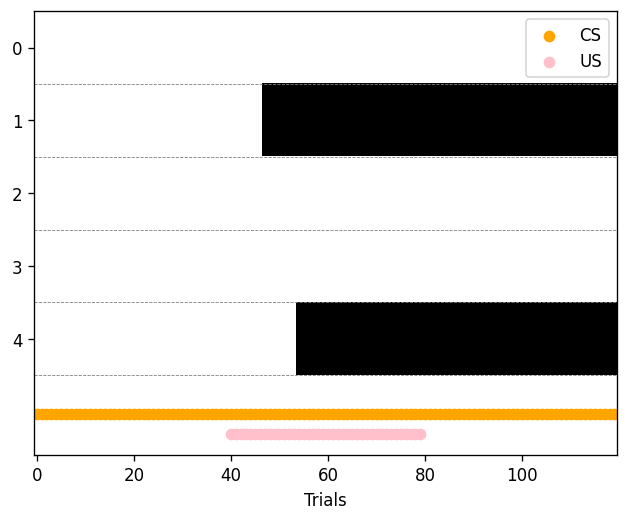

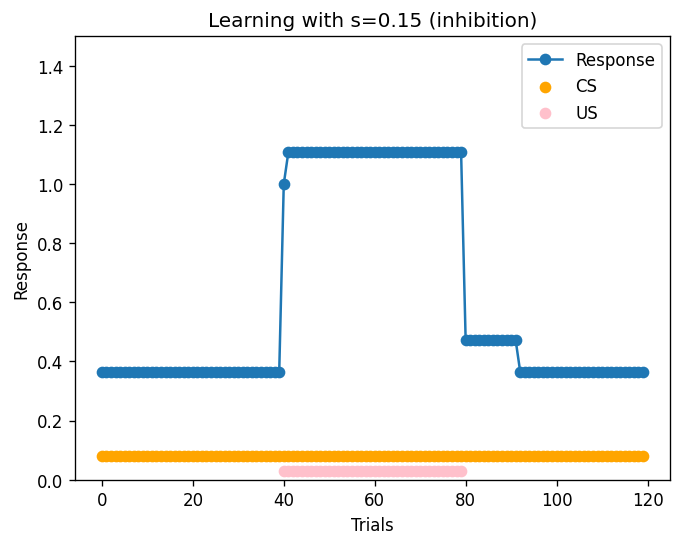

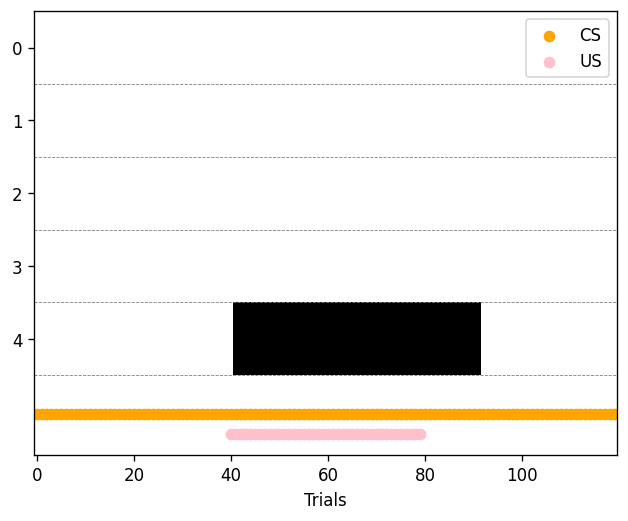

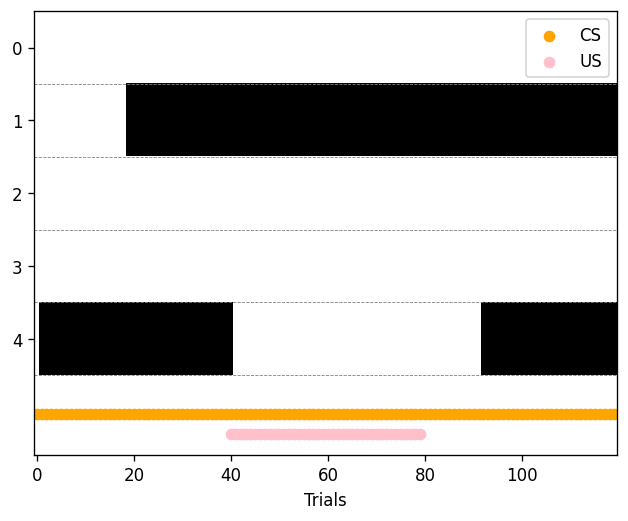

In [3]:
### 4 · Qualitative demonstration
CS_A = random_cs(5, f=0.5, seed=42)  # CS_A is a random CS
print(np.array(CS_A, dtype=int))


def learning(s, rep):
    gam = BetterGAM(N=5, p=.2, q=.2, p_l=.04, q_l=.20, s=s, G1 = sigmoid, G2 = elementwise_sigmoid)
    cs_seq, us_seq = [], []
    # Familiarization
    for _ in range(rep):
        cs_seq.append(CS_A); us_seq.append(0)  # CS only - no response

    for _ in range(rep):
        cs_seq.append(CS_A); us_seq.append(1)  # CS+US - learning
    # Test
    for _ in range(rep):
        cs_seq.append(CS_A); us_seq.append(0)  # CS only - response
    # get responses:
    responses = []
    memories = []
    Xs = []
    for cs, us in zip(cs_seq, us_seq):
        gam.present(cs, us)
        r = gam.response(cs, us)
        responses.append(r)
        memories.append(gam.get_m())
        Xs.append(gam.get_x())

    return cs_seq, us_seq, memories, responses, Xs

def plot_inner_state(memories,rep):
    plt.imshow(np.array(memories).T, cmap="Greys", aspect=15, interpolation='none')
    plt.xlabel("Trials")
    # plt.show()

    cs = np.array([True] * rep + [True] * rep + [True] * rep)
    ucs = np.array([0] * rep + [1] * rep + [0] * rep)

    plt.scatter(range(3*rep), cs * 5.03, label='CS', color='orange')
    plt.yticks([0,1,2,3,4])
    indices = np.where(ucs)[0]
    if indices.size > 0:
        plt.scatter(indices, ucs[indices] * 5.3, label='US', color='pink')
    plt.legend()
    for i in range(5):
        plt.axhline(i + .5, color='grey', linestyle='--', linewidth=0.5)
    plt.show()

plt.imshow(np.array(CS_A).reshape(-1,1), cmap="Greys", aspect=1, interpolation='none')
for i in range(5):
    plt.axhline(i + .5, color='grey', linestyle='--', linewidth=0.5)
plt.xlabel("Trials")
plt.xticks([])
plt.show()


rep = 40
cs_seq, us_seq, memories, responses, Xs = learning(s = 0, rep=rep)
plt.plot(range(3*rep), responses, marker='o', label='Response')
plt.ylim(0, 1.5)
plt.title("Learning with s=0 (no inhibition)")

cs = np.array([True] * rep + [True] * rep + [True] * rep)
ucs = np.array([0] * rep + [1] * rep + [0] * rep)
plt.scatter(range(3*rep), cs * 0.08, label='CS', color='orange')
indices = np.where(ucs)[0]
if indices.size > 0:
    plt.scatter(indices, ucs[indices] * 0.03, label='US', color='pink')
plt.legend()
plt.xlabel("Trials")
plt.ylabel("Response")
plt.show()

plot_inner_state(memories,rep)

s = 0.15
cs_seq, us_seq, memories, responses, Xs = learning(s = s, rep=rep)
plt.plot(range(3*rep), responses, marker='o', label='Response')
plt.ylim(0, 1.5)
plt.title(f"Learning with s={s} (inhibition)")
cs = np.array([True] * rep + [True] * rep + [True] * rep)
ucs = np.array([0] * rep + [1] * rep + [0] * rep)
plt.scatter(range(3*rep), cs * 0.08, label='CS', color='orange')
indices = np.where(ucs)[0]
if indices.size > 0:
    plt.scatter(indices, ucs[indices] * 0.03, label='US', color='pink')
plt.legend()
plt.xlabel("Trials")
plt.ylabel("Response")
plt.show()

plot_inner_state(memories, rep)
plot_inner_state(Xs, rep)


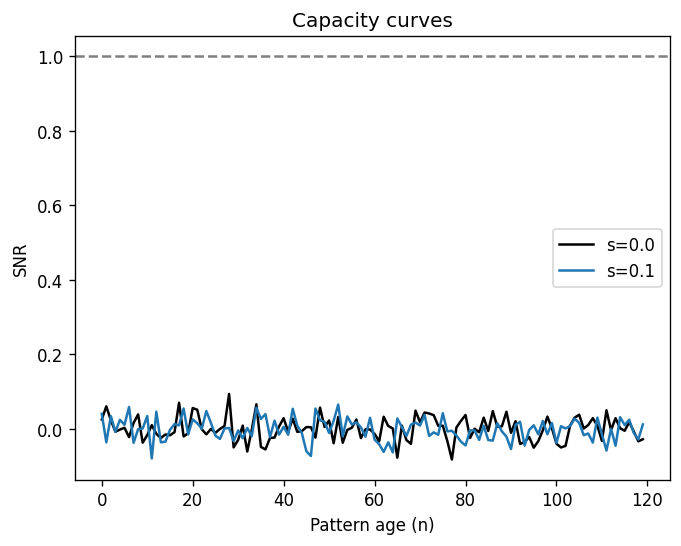

In [59]:
### 5 · Capacity curves (quick Monte‑Carlo)

def store_patterns(model, n_patterns, f=0.5):
    patterns = [random_cs(model.N, f) for _ in range(n_patterns)]
    # Encode sequentially with US
    for p in patterns:
        model.present(p, 1)
    return patterns

def snr_curve(model, patterns, test_size=200):
    # Compute SNR vs pattern age
    cr_means = []
    for age, patt in enumerate(patterns[::-1], 1):  # newest→oldest
        trials = [model.response(patt, 0) for _ in range(test_size)]
        cr_means.append(np.mean(trials))
    # Non‑learned distr
    non_trials = [model.response(random_cs(model.N), 0) for _ in range(test_size)]
    mu0, var0 = np.mean(non_trials), np.var(non_trials)
    snr = []
    for mu in cr_means:
        snr.append((mu - mu0) / np.sqrt(var0))
    return np.array(snr)

N_PATTERNS = 120
for s_val, col in [(0.0, 'k'), (0.10, 'tab:blue')]:
    g = BetterGAM(N=1000, p=.122, q=.122, p_l=.04, q_l=.20, s=s_val)
    patterns = store_patterns(g, N_PATTERNS)
    snr = snr_curve(g, patterns)
    plt.plot(snr, label=f's={s_val}', color=col)
plt.axhline(1, ls='--', color='grey')
plt.xlabel('Pattern age (n)')
plt.ylabel('SNR')
plt.title('Capacity curves')
plt.legend()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Fixed CS pattern
def random_cs(N: int, f: float = 0.5, rng=None, seed=None) -> np.ndarray:
    rng = rng or np.random.default_rng(seed=seed)
    return (rng.random(N) < f)

# Simple nonlinear response (sigmoid of mean overlap)
def sigmoid(x, beta=3.0):
    return 1 / (1 + np.exp(-beta * (x - 0.5)))

def elementwise_sigmoid(C, M, beta=3.0):
    mean = np.mean(C.flatten() * M.flatten()).astype(float)
    return sigmoid(mean, beta=beta)

# Run learning protocol and return responses
def run_learning(gam: BetterGAM, rep: int, familiarization: bool) -> List[float]:
    cs_seq, us_seq = [], []

    if familiarization:
        for _ in range(rep):
            cs_seq.append(CS_A); us_seq.append(0)  # CS only

    for _ in range(rep):
        cs_seq.append(CS_A); us_seq.append(1)  # CS+US

    responses = []
    for cs, us in zip(cs_seq, us_seq):
        gam.present(cs, us)
        r = gam.response(cs, us)
        responses.append(r)
    return responses

# Measure time from start of US phase to peak response
def time_to_peak(responses: List[float], rep: int, familiarization: bool) -> int:
    offset = rep if familiarization else 0
    us_phase_responses = responses[offset : offset + rep]
    peak_idx = np.argmax(us_phase_responses)
    return peak_idx

# -------------------------------------------------------------
# Parameters
N = 5
rep = 40
n_runs = 1000
rng = np.random.default_rng(seed=42)

# Fixed CS pattern
CS_A = random_cs(N, f=0.5, rng=rng)

# 2 GAM models
models_params = [
    {'name': 's=0', 's': 0},
    {'name': 's=0.15', 's': 0.15}
]

# Experiment
results = {}  # (model, familiarization) -> list of times to peak

for params in models_params:
    for familiarization in [False, True]:
        key = (params['name'], familiarization)
        times = []
        for run in range(n_runs):
            gam = BetterGAM(N=N, p=.2, q=.2, p_l=.04, q_l=.20, s=params['s'],
                            G1=sigmoid, G2=elementwise_sigmoid)
            responses = run_learning(gam, rep, familiarization)
            t_peak = time_to_peak(responses, rep, familiarization)
            times.append(t_peak)
        results[key] = times

# Report
print("Results (time from start of US to peak response):")
for params in models_params:
    for familiarization in [False, True]:
        key = (params['name'], familiarization)
        times = np.array(results[key])
        mean = times.mean()
        std = times.std()
        fam_text = "with familiarization" if familiarization else "no familiarization"
        print(f"Model={params['name']}, {fam_text}: mean={mean:.2f}, std={std:.2f}")



Results (time from start of US to peak response):
Model=s=0, no familiarization: mean=6.26, std=5.04
Model=s=0, with familiarization: mean=6.14, std=4.73
Model=s=0.15, no familiarization: mean=6.38, std=5.17
Model=s=0.15, with familiarization: mean=17.77, std=11.10


In [20]:
import numpy as np
from BlockingGAM import BetterGAM_RW

# Simple sigmoid readout
def sigmoid(x, beta=3.0):
    return 1 / (1 + np.exp(-beta * (x - 0.5)))

def elementwise_sigmoid(C, M, beta=3.0):
    mean = np.mean(C * M)
    return sigmoid(mean, beta=beta)

# Fixed random CS patterns
N = 100
rng = np.random.default_rng(seed=0)
CS1 = (rng.random(N) < 0.5)
CS2 = (rng.random(N) < 0.5)
CS1_plus_CS2 = CS1 | CS2

n_runs = 100
rep = 100  # trials in each phase
responses_blocking = []
responses_control = []
responses_CS1 = []

for _ in range(n_runs):
    # Blocking model
    model = BetterGAM_RW(N=100, p=0.9, q=0.1, p_l=0.3, q_l=0.1, s=0.1,
                     G1=sigmoid, G2=elementwise_sigmoid)

    # Phase 1: CS1+US
    for _ in range(rep):
        model.present(CS1, 1)

    # Phase 2: CS1+CS2+US
    for _ in range(rep):
        model.present(CS1_plus_CS2, 1)

    # Test: CS2 alone
    resp_CS2 = model.response(CS2, 0)
    responses_blocking.append(resp_CS2)

    # Test: CS1 alone
    resp_CS1 = model.response(CS1, 0)
    responses_CS1.append(resp_CS1)

    # ---------------------------
    # Control model: CS2+US directly
    model2 = BetterGAM_RW(N=100, p=0.9, q=0.1, p_l=0.3, q_l=0.1, s=0.1,
                     G1=sigmoid, G2=elementwise_sigmoid)
    for _ in range(rep):
        model2.present(CS2, 1)

    # Test: CS2 alone
    resp2 = model2.response(CS2, 0)
    responses_control.append(resp2)

responses_blocking = np.array(responses_blocking)
responses_control = np.array(responses_control)
responses_CS1 = np.array(responses_CS1)

print("Blocking experiment results (response to CS2):")
print(f"Blocking: mean={responses_blocking.mean():.3f}, std={responses_blocking.std():.3f}")
print(f"Control : mean={responses_control.mean():.3f}, std={responses_control.std():.3f}")
print("\nResponse to CS1 alone after blocking protocol:")
print(f"Mean={responses_CS1.mean():.3f}, std={responses_CS1.std():.3f}")

Blocking experiment results (response to CS2):
Blocking: mean=0.635, std=0.004
Control : mean=0.636, std=0.003

Response to CS1 alone after blocking protocol:
Mean=0.637, std=0.001
